In [849]:
import xml.etree.ElementTree as ET
from collections import namedtuple
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [158]:
plt.style.use('ggplot')

In [1426]:
InputDescription = namedtuple('InputDescription', ['name', 'minimum', 'maximum'])

def rescale_value(x, min, max):
    return (x - min) / (max - min)

def load_file(filename, rescale=True):
    tree = ET.parse(filename)
    root = tree.getroot()
    
    inputsCount = int(root.find('inputsCount').text)
    inputDescriptions = []
    for node in root.find('inputDescriptions').findall('inputDescription'):
        inputDescriptions.append(InputDescription(
            node.find('name').text, 
            float(node.find('minimum').text), 
            float(node.find('maximum').text)))
    assert inputsCount == len(inputDescriptions)
        
    learningRate = float(root.find('learningRate').text)

    layersCount = int(root.find('layersCount').text)
    layers = []
    for node in root.find('neuronInLayersCount').findall('neuronInLayerCount'):
        layers.append(int(node.text))
    assert layersCount == len(layers)
    
    outputDescriptions = []
    for node in root.find('outputDescriptions').findall('outputDescription'):
        outputDescriptions.append(node.text)
        
    test = []
    for element in root.find('testSet').findall('testSetElement'):
        inputs = []
        for node, desc in zip(element.find('inputs').findall('value'), inputDescriptions):
            value = float(node.text)
            if rescale:
                value = rescale_value(value, desc.minimum, desc.maximum)
            inputs.append(value)
        test.append(inputs)
        
    train_x = []
    train_y = []
    for element in root.find('trainSet').findall('trainSetElement'):
        inputs = []
        for node, desc in zip(element.find('inputs').findall('value'), inputDescriptions):
            value = float(node.text)
            if rescale:
                value = rescale_value(value, desc.minimum, desc.maximum)
            inputs.append(value)
        outputs = []
        for node in element.find('outputs').findall('value'):
            outputs.append(float(node.text))
        train_x.append(inputs)
        train_y.append(outputs)
    
    return {
        'inputDescriptions': inputDescriptions,
        'learningRate': learningRate,
        'layers': layers,
        'outputDescriptions': outputDescriptions,
        'test': test,
        'train': (train_x, train_y)
    }

In [1446]:
%run NeuralNet.py

In [1429]:
def plot_space(nn, mi=0, ma=1, step=0.01):
    v = np.arange(mi, ma + step)
    x0, x1 = np.meshgrid(v, v)
    data_x = np.c_[x0.flatten(), x1.flatten()]
    data_y = np.array(nn.predict(data_x)).flatten()

    plt.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r)
    
def plot_train(x, y):
    x0 = list(map(lambda x: x[0], x))
    x1 = list(map(lambda x: x[1], x))
    
    x0a, x1a = [], [] # 0
    x0b, x1b = [], [] # 1
    for xi, y in zip(x, y):
        if y[0] == 0:
            x0a.append(xi[0])
            x1a.append(xi[1])
        else:
            x0b.append(xi[0])
            x1b.append(xi[1])
    
    plt.scatter(x0a, x1a, marker="o", label="train 0", c="r")
    plt.scatter(x0b, x1b, marker="x", label="train 1", c="b")
    
def plot_predicted(x, y):
    x0 = list(map(lambda x: x[0], x))
    x1 = list(map(lambda x: x[1], x))
    
    x0a, x1a = [], [] # 0
    x0b, x1b = [], [] # 1
    for xi, y in zip(x, y):
        if y[0] == 0:
            x0a.append(xi[0])
            x1a.append(xi[1])
        else:
            x0b.append(xi[0])
            x1b.append(xi[1])
    
    plt.scatter(x0a, x1a, marker="o", label="predict 0", c="r", s=100)
    plt.scatter(x0b, x1b, marker="x", label="predict 1", c="b", s=100)
    
def plot_space_train_test(nn, configuration):
    step = 0.005
    v = np.arange(0, 1 + step)
    x0, x1 = np.meshgrid(v, v)
    data_x = np.c_[x0.flatten(), x1.flatten()]
    data_y = np.round(np.array(nn.predict(data_x)).flatten())
    plt.contourf(x0, x1, data_y.reshape(x0.shape), cmap=plt.cm.bwr_r, alpha=0.25)
    
    train_x, train_y = configuration['train']
    test_x = configuration['test']
    predicted_y = np.round(nn.predict(test_x))
    
    plot_train(train_x, train_y)
    plot_predicted(test_x, predicted_y)
    plt.legend()

---

In [ ]:
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
nn = NeuralNetworkBuilder.build(2, [2, 2], LeakyReLU())

i1, i2 = nn.layers[0]
h1, h2 = nn.layers[1]
o1, o2 = nn.layers[2]

h1.b = h2.b = 0.35
o1.b = o2.b = 0.6
w1, w2 = h1.inputs
w3, w4 = h2.inputs
w5, w6 = o1.inputs
w7, w8 = o2.inputs

w1.w = 0.15
w2.w = 0.2
w3.w = 0.25
w4.w = 0.3
w5.w = 0.4
w6.w = 0.45
w7.w = 0.5
w8.w = 0.55

train_x = [[0.05, 0.1]]
train_y = [[0.01, 0.99]]

display(nn.predict(train_x))

epochs = 100
loss = []
for i in range(epochs):
    loss.append(nn.train(train_x, train_y, 0.5))
display(nn.predict(train_x))
plt.plot(loss)
plt.show()

#loss_sigmoid = loss
#loss_relu = loss
loss_leakyrelu = loss

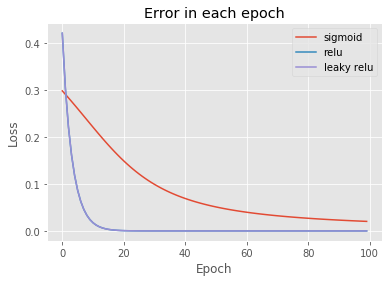

In [1137]:
plt.plot(loss_sigmoid, label='sigmoid')
plt.plot(loss_relu, label='relu')
plt.plot(loss_leakyrelu, label='leaky relu')
plt.legend()
plt.title("Error in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

---

[[0.7339484822837109],
 [0.7741567028031714],
 [0.7826266978512963],
 [0.8134479727603932]]

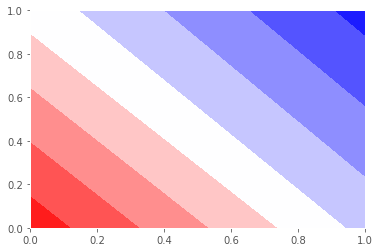

[[0.040541497462960666],
 [0.9659156893752635],
 [0.9628209131576915],
 [0.03920504116215987]]

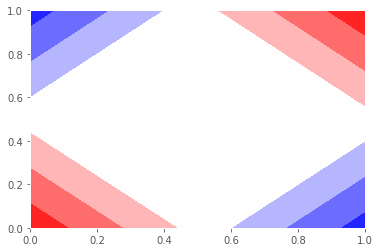

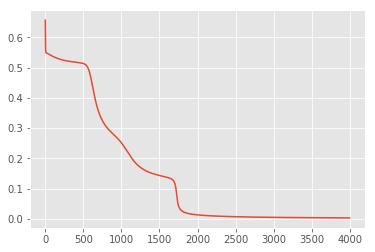

In [1459]:
## XOR ... doesnt work for some reason
nn = NeuralNetworkBuilder.build(2, [4, 1], Sigmoid())
train_x = [[0, 0], [0, 1], [1, 0], [1, 1]]
train_y = [[0], [1], [1], [0]]

display(nn.predict(train_x))
plot_space(nn)
plt.show()

epochs = 4000
loss = []
for i in range(epochs):
    #display(nn.predict(train_x))
    loss.append(nn.train(train_x, train_y, 1))

display(nn.predict(train_x))
plot_space(nn)
plt.show()
plt.plot(loss)
plt.show()

---

In [1430]:
def run_configuration(configuration, epochs, activation):
    train_x, train_y = configuration['train']
    nn = NeuralNetworkBuilder.build(len(configuration['inputDescriptions']), configuration['layers'], activation)
    
    loss = []
    for _ in range(epochs):
        loss.append(nn.train(train_x, train_y, configuration['learningRate']))
    
    predicted = np.round(nn.predict(c['train'][0]))
    expected = c['train'][1]
    score = np.sum([result.all() for result in predicted == expected])
    total = len(predicted)
    print(f"Score: {score}/{total} ({score/total * 100:2.1f}%)")
    
    plt.title(f"Error in each epoch ({activation.__class__.__name__})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    return nn, loss

def train_more(nn, configuration, epochs):
    train_x, train_y = configuration['train']
    
    loss = []
    for _ in range(epochs):
        loss.append(nn.train(train_x, train_y, configuration['learningRate']))
    
    predicted = np.round(nn.predict(c['train'][0]))
    expected = c['train'][1]
    score = np.sum([result.all() for result in predicted == expected])
    total = len(predicted)
    print(f"Score: {score}/{total} ({score/total * 100:2.1f}%)")

Score: 3/3 (100.0%)


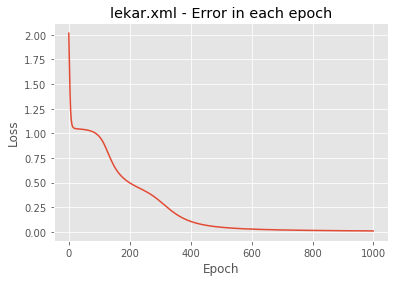

In [1438]:
c = load_file("lekar.xml")
epochs = 1000
nn, loss_sigmoid = run_configuration(c, epochs, Sigmoid())

plt.plot(loss_sigmoid)
plt.title("lekar.xml - Error in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Score: 18/18 (100.0%)


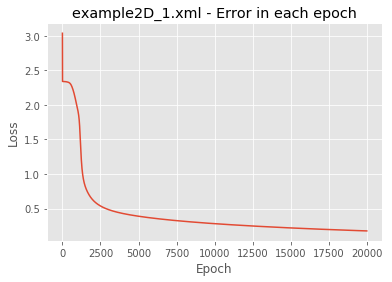

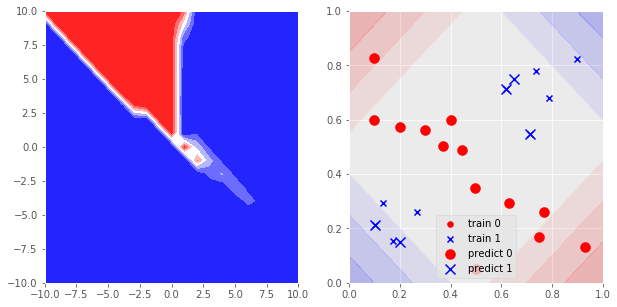

In [1442]:
c = load_file("example2D_1.xml")
nn, loss_sigmoid = run_configuration(c, 20000, Sigmoid())

plt.plot(loss_sigmoid, label='sigmoid')
plt.title("example2D_1.xml - Error in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_space(nn, -10, 10, 1)
plt.subplot(1, 2, 2)
plot_space_train_test(nn, c)
plt.show()

Score: 34/35 (97.1%)


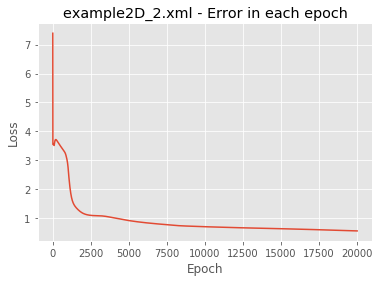

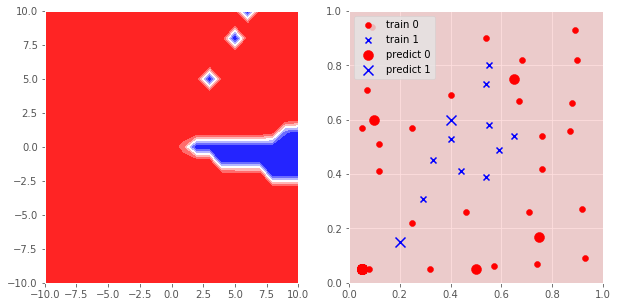

In [1443]:
c = load_file("example2D_2.xml")
nn, loss_sigmoid = run_configuration(c, 20000, Sigmoid())

plt.plot(loss_sigmoid)
plt.title("example2D_2.xml - Error in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_space(nn, -10, 10, 1)
plt.subplot(1, 2, 2)
plot_space_train_test(nn, c)
plt.show()

Score: 27/31 (87.1%)


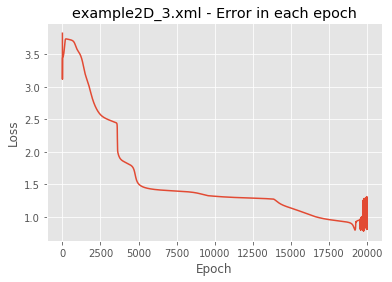

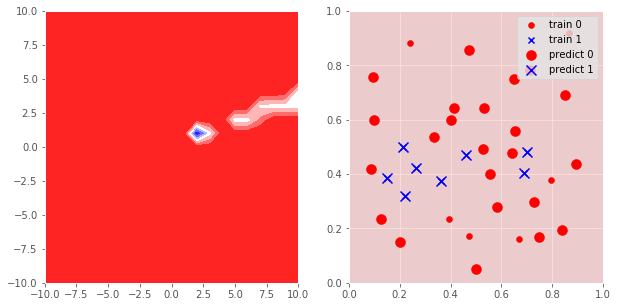

In [1444]:
c = load_file("example2D_3.xml")
nn, loss_sigmoid = run_configuration(c, 20000, Sigmoid())

plt.plot(loss_sigmoid)
plt.title("example2D_3.xml - Error in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_space(nn, -10, 10, 1)
plt.subplot(1, 2, 2)
plot_space_train_test(nn, c)
plt.show()